# Import all necessary packages

In [1]:
import os
os.chdir(os.path.expanduser(os.getcwd()))
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import seaborn as sns
import plotly.express as px
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

# my modules
from modules import wrangle

## Data Warangling and Preprocessing

Path of the Reanalysis and GCM netCDF Files

In [2]:
path_station = r"F:\Reanalysis Data\Monthly\Observed\Ground WaterGT294700720321.xlsx"
# Directory containing the reanalysis NetCDF files
path_reanalysis = r"F:\Reanalysis Data\Monthly\Reanalysis"
# Directory containing the gcm NetCDF files
path_gcm = r"F:\Reanalysis Data\Monthly\GCM\ACCESS ESM 15\historical"

Returns the *original* dataframe, *reanalysis* dataframe, *gcm* dataframe

In [3]:
df = wrangle(path_station, path_reanalysis, path_gcm)

Predicted well with current config:
1. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT041900320314.xlsx"
2. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT091800120315.xlsx"
3. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT092500220316.xlsx"
4. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT121300520345.xlsx"
5. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT132200420333.xlsx"
6. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT158603420328.xlsx" (Many Missing Data)
7. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT193101220332.xlsx"
8. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT196790020307.xlsx"
9. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT221600220350.xlsx"
10. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT229001420325.xlsx"
11. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT274702120340.xlsx"
12. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT276403020355.xlsx"
13. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT294700720321.xlsx" (good) (show)
14. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT294790020306.xlsx" (good)
15. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT302900420331.xlsx"
16. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT328201120341.xlsx" (good)
17. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT355101020343.xlsx" (good)
18. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT393690020312.xlsx" (good)
19. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT483301020335.xlsx" (good)
20. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT497700420336.xlsx" (good)
21. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT501590020308.xlsx" (Many Missing Data)
22. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT544000120318.xlsx" (good)
23. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT588303020352.xlsx" (underfit)
24. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT612301920320.xlsx"
25. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT615290020313.xlsx"
26. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT685200120348.xlsx"
27. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT753600620330.xlsx"
28. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT765590020310.xlsx" (good)
29. "F:\Reanalysis Data\Monthly\Observed\Ground WaterGT785700120317.xlsx"

### Watertable data

In [4]:
df[0].isnull().sum()

8
DISTRICT              0
UPAZILA               0
WELL ID               0
OLD ID                0
WATER TABLE (m)       0
RL PARAPET (m)        0
PARAPET HEIGHT (m)    0
DEPTH (m)             0
LATITUDE              0
LONGITUDE             0
dtype: int64

### Fill Missing Values with Avg. Monthly Mean

In [5]:
df_not_imputed = df[0]["WATER TABLE (m)"].resample('MS').mean()
df_not_imputed.isnull().sum()

23

In [6]:
from modules import monthly_mean_imputer

imputed = monthly_mean_imputer(df[0]["WATER TABLE (m)"], "wtable")

In [7]:
imputed

DATE TIME
1980-01-01    5.7300
1980-02-01    5.6025
1980-03-01    5.7760
1980-04-01    5.9175
1980-05-01    4.8875
               ...  
2020-09-01    1.7375
2020-10-01    1.9500
2020-11-01    2.7400
2020-12-01    3.6750
2021-01-01    4.3500
Freq: MS, Name: wtable, Length: 493, dtype: float64

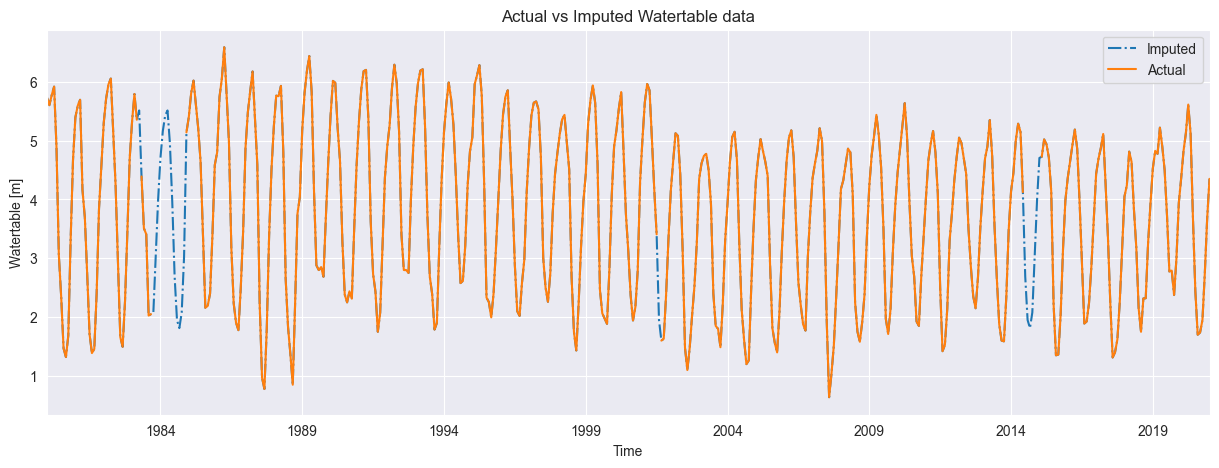

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
imputed.plot(ax=ax, style=["-."])
df_not_imputed.plot(ax=ax)
plt.xlabel("Time")
plt.ylabel("Watertable [m]")
plt.title("Actual vs Imputed Watertable data")
ax.legend(["Imputed", "Actual"]);

## Exploratory Data Analysis

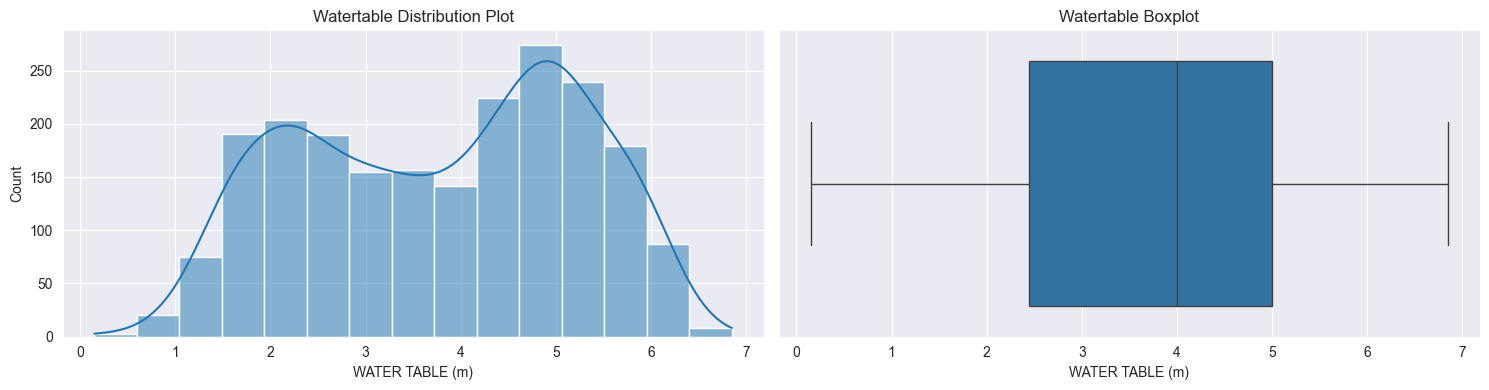

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,4), )
# Distribution plot
sns.histplot(data = df[0], x="WATER TABLE (m)", kde=True, bins=15, ax=axs[0])
axs[0].set_title("Watertable Distribution Plot")
# Boxplot of Residuals
sns.boxplot(x="WATER TABLE (m)", data=df[0], orient="v", ax=axs[1])
axs[1].set_title("Watertable Boxplot")

plt.tight_layout()

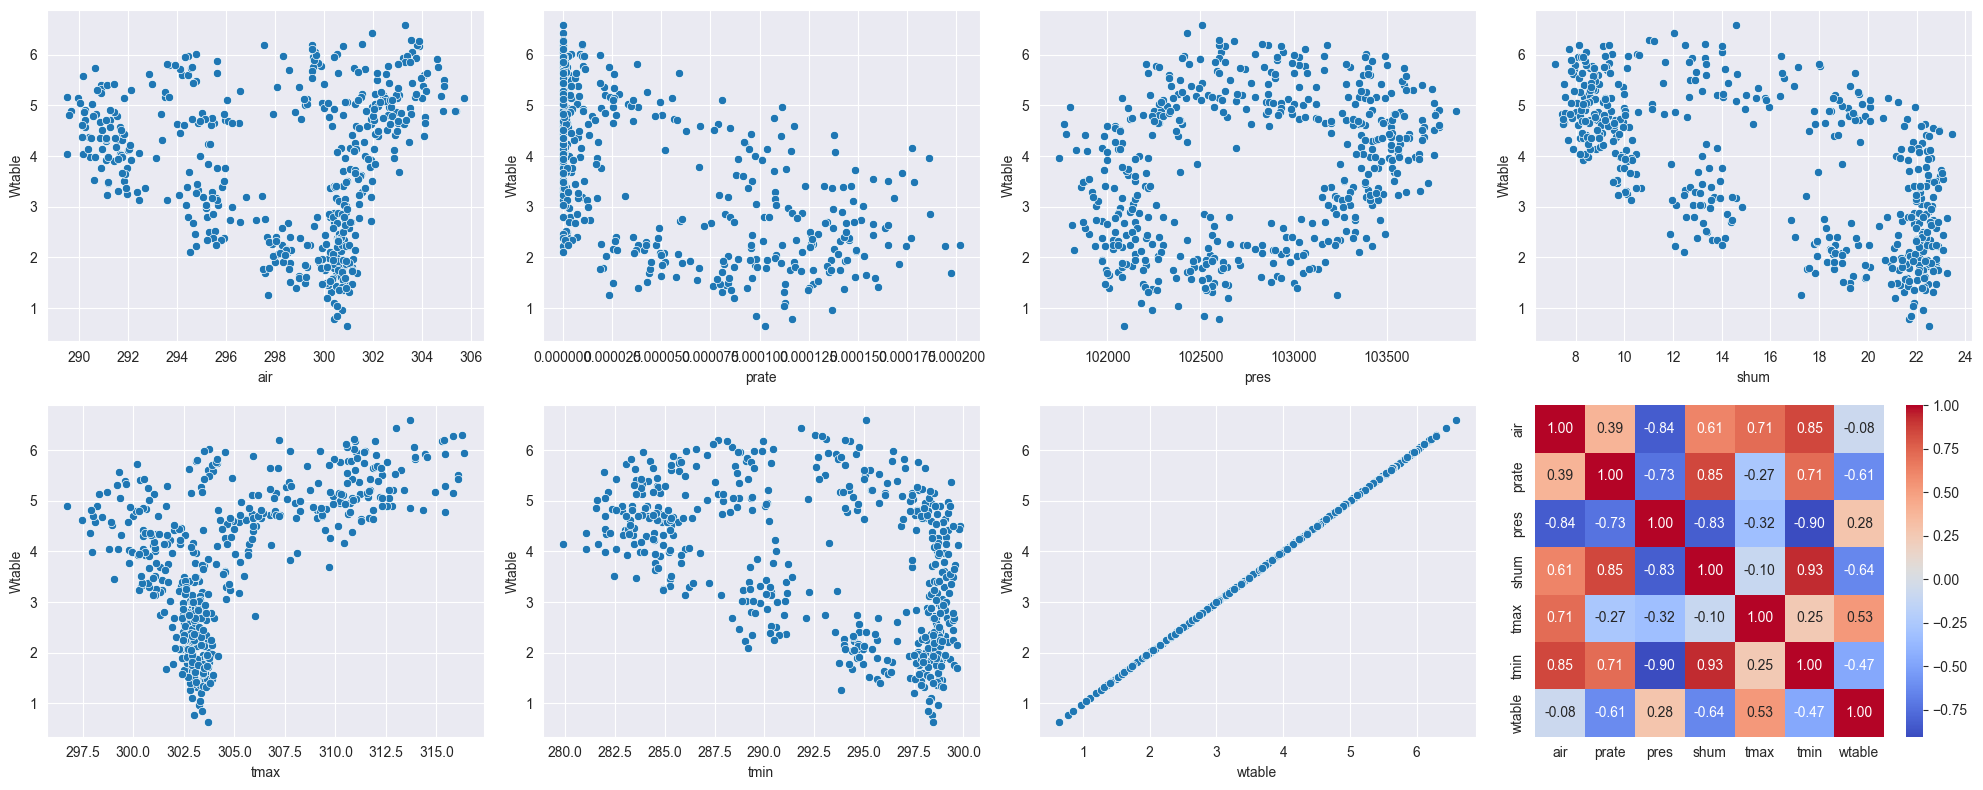

In [10]:
# Creating a temporary dataframe
temp = df[1].copy()
temp['wtable'] = imputed

num_columns = len(temp.columns)
rows = (num_columns + 1) // 4 
fig, axs = plt.subplots(rows, 4, figsize=(20, 8))
axs = axs.flatten()

# Loop through the columns in temp to create scatter plots
for i, column in enumerate(temp.columns):
    sns.scatterplot(x=temp[column], y=temp['wtable'], ax=axs[i])
    # axs[i].scatter(x=temp[column], y=temp['wtable'])
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Wtable')  # Add ylabel for clarity
    
# Add correlation matrix at the last plot
sns.heatmap(temp.corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axs[len(temp.columns)])

# Remove any empty subplots if there are more than needed
for j in range(len(temp.columns) + 1, 8):  # Assuming we have 8 total slots
    fig.delaxes(axs[j // 4, j % 4])

plt.tight_layout()

# remove temp from RAM
del temp

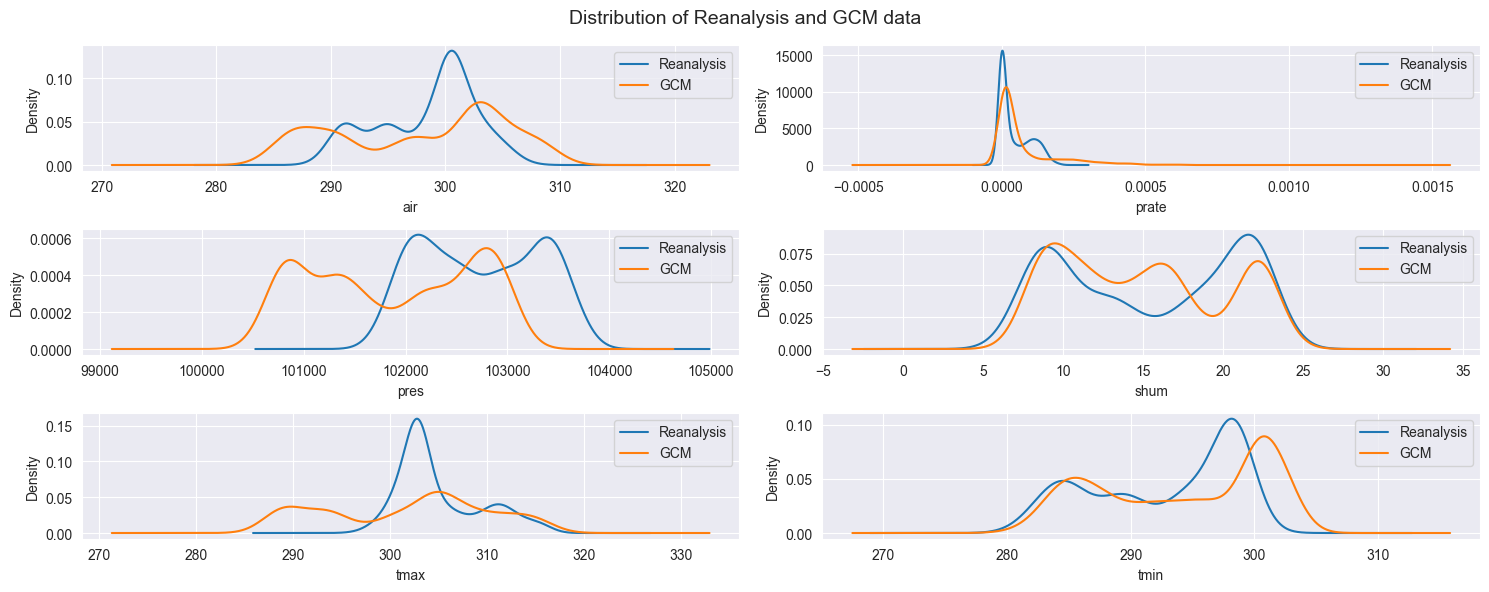

In [11]:
from modules import plot_features_distributions

plot_features_distributions(df[1], df[-1]) 

## Feature Engineering

Using sine and cosine for periodic attributes offers several advantages: 
- **Cyclical Pattern Recognition:** Helps the model's understanding of the proximity between the cycle's end and beginning.
- **Dimensionality Control:** Avoids the excessive feature expansion seen with one-hot encoding.
- **Predictive Performance:** Enhances accuracy, particularly in time-series analysis, by utilizing the continuous nature of sine and cosine features.res.

In [12]:
from modules import add_seasons


y = imputed

X = df[1].loc[y.index[0]: y.index[-1]].copy()
X.loc[:, 'month'] = X.index.month
X.loc[:, 'quarter'] = X.index.quarter
# X.loc[:, 'year'] = X.index.year

X.loc[:, 'season'] = add_seasons(X.index)
# Adding cyclic features (optional)
X.loc[:, 'month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X.loc[:, 'month_cos'] = np.cos(2 * np.pi * X['month'] / 12)

X_gcm = df[-1]
X_gcm.loc[:, 'month'] = X_gcm.index.month
# X_gcm = gcm.loc[y.index[-1]:].copy()
X_gcm.loc[:, 'quarter'] = X_gcm.index.quarter
X_gcm.loc[:, 'season'] = add_seasons(X_gcm.index)
# Adding cyclic features (optional)
X_gcm.loc[:, 'month_sin'] = np.sin(2 * np.pi * X_gcm['month'] / 12)
X_gcm.loc[:, 'month_cos'] = np.cos(2 * np.pi * X_gcm['month'] / 12)
# X_gcm.loc[:, 'year'] = X_gcm.index.year
X.drop(columns='month', inplace=True)
X_gcm.drop(columns='month', inplace=True)
X_gcm.head()

,air,prate,pres,shum,tmax,tmin,quarter,season,month_sin,month_cos
time_bnds,,,,,,,,,,
1850-01-01,286.309540,0.000019,102947.218750,8.289968,288.404388,284.280396,1,Winter,0.500000,8.660254e-01
1850-02-01,289.993896,0.000012,102659.210938,10.270108,293.025726,286.759094,1,Winter,0.866025,5.000000e-01
1850-03-01,296.617096,0.000009,102131.054688,11.152504,301.879974,291.052368,1,Spring,1.000000,6.123234e-17
1850-04-01,302.047119,0.000033,101687.609375,12.304470,308.302521,295.220581,2,Summer,0.866025,-5.000000e-01
1850-05-01,305.370728,0.000023,101531.671875,15.401556,311.560669,299.809265,2,Summer,0.500000,-8.660254e-01


## Train-Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Models

In [14]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['season'], use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [15]:
y_pred = model.predict(X_test)

In [16]:
print("Train MSE and r2", mean_squared_error(y_train, model.predict(X_train)), r2_score(y_train, model.predict(X_train)))
print("Test MSE and r2", mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred))

Train MSE and r2 0.23566187899092408 0.8847549746829042
Test MSE and r2 0.28622758800357506 0.866352998236919


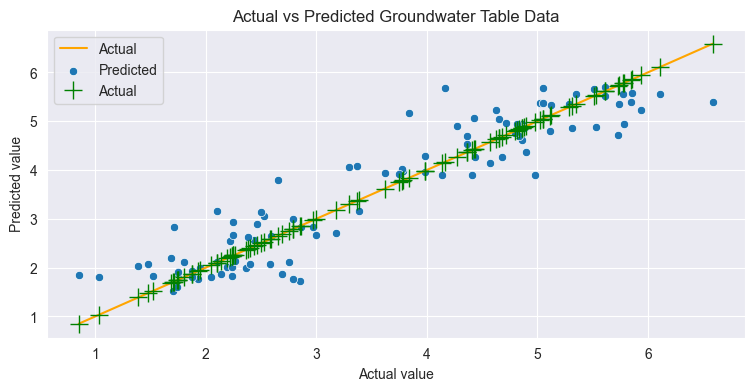

In [17]:
plt.figure(figsize=(9, 4))
# Plot the diagonal line for actual values (rehape converts 2d array to 1d)
sns.lineplot(x=y_test.values.reshape(-1), y=y_test.values.reshape(-1), color="orange", label="Actual")
sns.scatterplot(x=y_test.values.reshape(-1), y=y_pred.reshape(-1), label="Predicted")
# Overlay actual values with a different style
plt.plot(y_test.values, y_test.values, "g+", markersize=13, label="Actual")
plt.title("Actual vs Predicted Groundwater Table Data")
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.legend();

## Residual Statistics

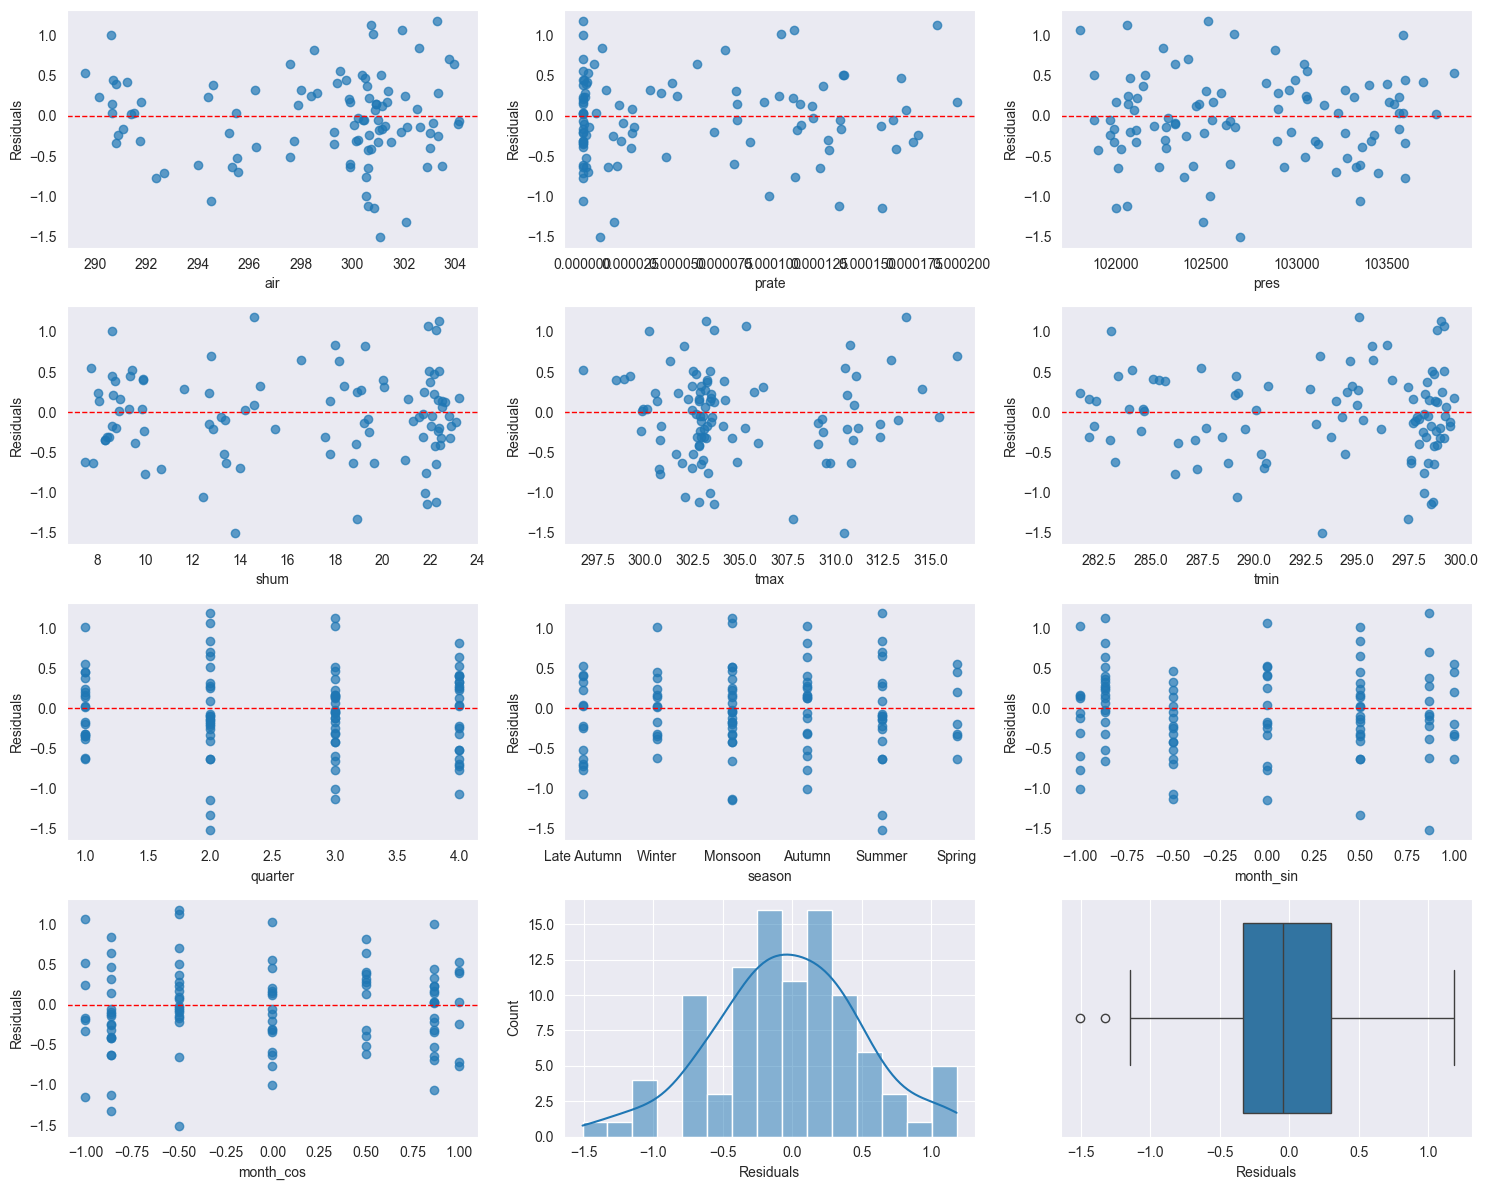

In [18]:
from modules import plot_residual_diagonistics

plot_residual_diagonistics(
    pd.Series((y_test - y_pred).values, name="Residuals"),
    X_test
)

Add year to the drop columns if you add year feature

Final Model Trained with All Data

In [19]:
model_final = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)
model_final.fit(X, y)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['season'], use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [20]:
downscaled = model_final.predict(X_gcm[X_test.columns])
downscaled = pd.Series(data = downscaled.reshape(-1), index=X_gcm.index, name='wtable')

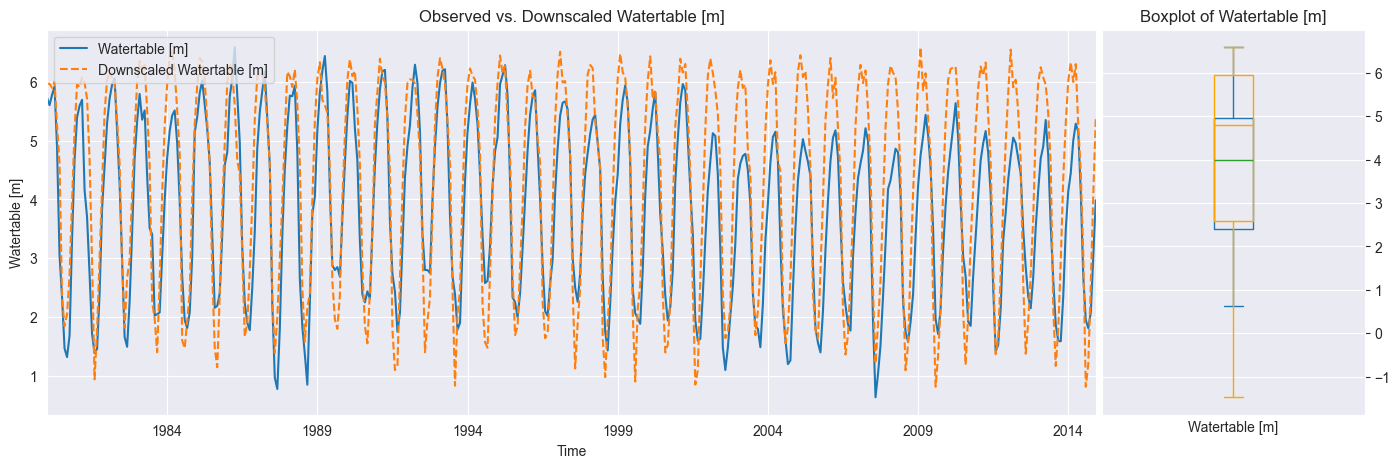

In [21]:
from modules import plot_compare_time_series_and_boxplot

plot_compare_time_series_and_boxplot(y, downscaled, variable_name="Watertable [m]")

# LinearScaling Bias Correction (Additive)

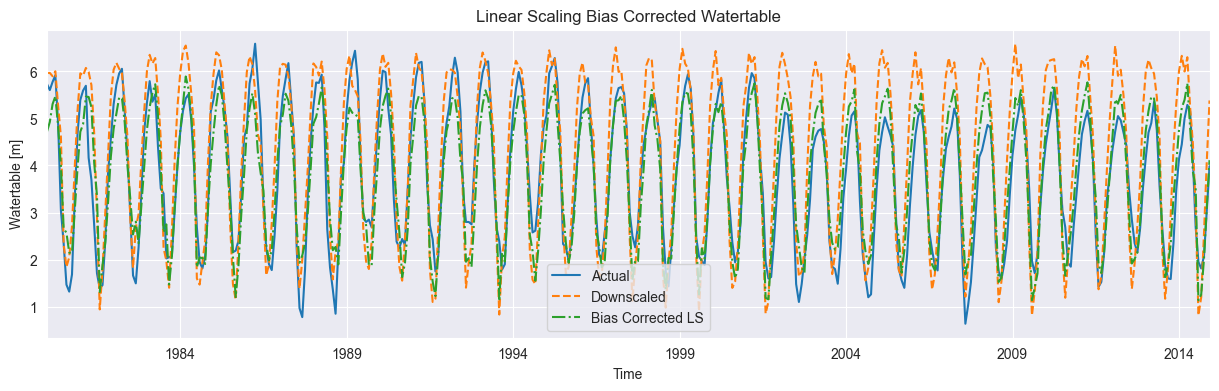

In [22]:
from modules import linear_scaling


fig, ax = plt.subplots(figsize=(15,4))
y.loc[:downscaled.index[-1]].plot(ax=ax)
downscaled.loc[y.index[0]: ].plot(ax=ax, style=["--"])
linear_scaling(y, downscaled, method="multiplicative").loc[y.index[0]: ].plot(ax=ax, style=["-."])
plt.xlabel("Time")
plt.ylabel("Watertable [m]")
plt.title("Linear Scaling Bias Corrected Watertable")
ax.legend(["Actual", "Downscaled", "Bias Corrected LS"]);

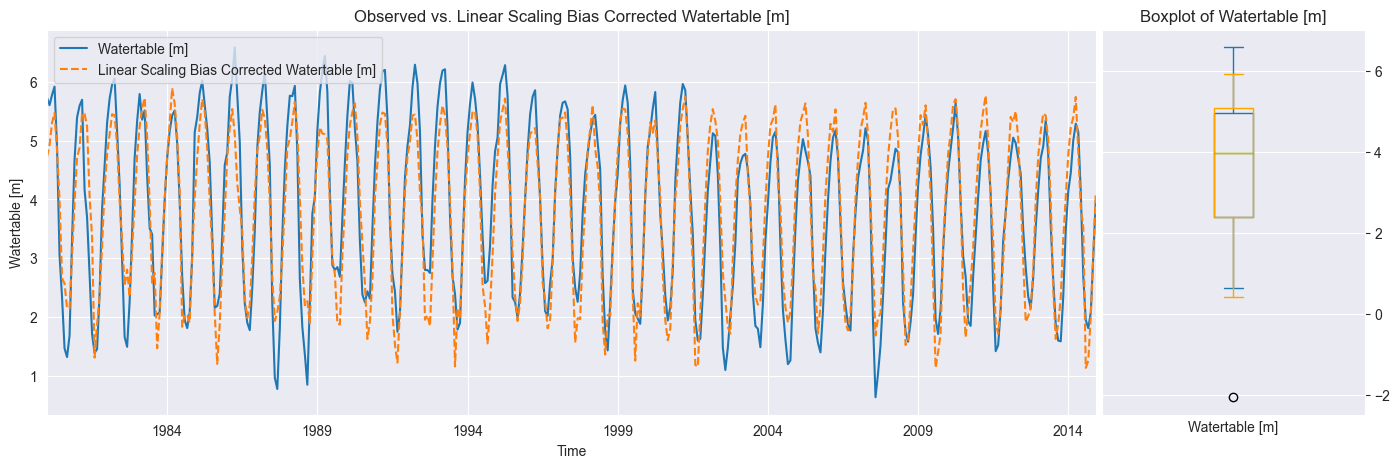

In [23]:
plot_compare_time_series_and_boxplot(y, linear_scaling(y, downscaled, method="multiplicative"), variable_name="Watertable [m]",
                                     alt_legend= "Linear Scaling Bias Corrected")

# Nested Bias Correction [NBC]

In [ ]:
# import pandas as pd
# import numpy as np


# def linear_scaling(y_observed, y_predicted, variable_name="linear_scaling_bias_corrected", method="additive"):
#     """
#     Corrects biases in the predicted values using the linear scaling method. 
#     The method can be either additive or multiplicative.

#     Note: Series must contain a DatetimeIndex.

#     Args:
#         y_observed (pandas.Series): Observed values of the variable with a DatetimeIndex.
#         y_predicted (pandas.Series): Predicted values of the variable with a DatetimeIndex.
#         variable_name (str, optional): Name for the corrected series. Defaults to "linear_scaling_bias_corrected".
#         method (str, optional): Method for bias correction - "additive" or "multiplicative". Defaults to "additive".

#     Returns:
#         pandas.Series: Bias-corrected predicted values.

#     Raises:
#         ValueError: If the input method is not "additive" or "multiplicative".
#         ValueError: If the input series do not have a DatetimeIndex.
#     """

#     # Ensure the inputs are pandas Series
#     if not isinstance(y_observed, pd.Series) or not isinstance(y_predicted, pd.Series):
#         raise ValueError(
#             "Both y_observed and y_predicted must be pandas Series.")

#     # Ensure the inputs have a DatetimeIndex
#     if not (pd.api.types.is_datetime64_any_dtype(y_observed.index) and
#             pd.api.types.is_datetime64_any_dtype(y_predicted.index)):
#         raise ValueError(
#             "Both y_observed and y_predicted must have a DatetimeIndex.")

#     # Add month information for grouping
#     observed_monthly_mean = y_observed.groupby(y_observed.index.month).mean()
#     predicted_monthly_mean = y_predicted.groupby(
#         y_predicted.index.month).mean()

#     # Compute correction factor based on the selected method
#     if method == "additive":
#         correction_factor = observed_monthly_mean - predicted_monthly_mean
#         corrected_values = y_predicted + \
#             y_predicted.index.month.map(correction_factor)
#     elif method == "multiplicative":
#         correction_factor = observed_monthly_mean / predicted_monthly_mean
#         corrected_values = y_predicted * \
#             y_predicted.index.month.map(correction_factor)
#     else:
#         raise ValueError(
#             "Invalid method. Choose either 'additive' or 'multiplicative'.")

#     # Return the corrected series
#     corrected_series = corrected_values.rename(variable_name)
#     return corrected_series


# def standardize_by_month(series):
#     """
#     Standardizes the values in the series by subtracting the monthly mean 
#     and dividing by the monthly standard deviation.

#     Args:
#         series (pd.Series): A pandas Series with a datetime index.

#     Returns:
#         pd.Series: A pandas Series of standardized values.
#     """
#     if not isinstance(series, pd.Series):
#         raise ValueError("Input must be a pandas Series.")

#     if not pd.api.types.is_datetime64_any_dtype(series.index):
#         raise ValueError("The Series must have a datetime index.")

#     # Group by month and calculate mean and standard deviation
#     monthly_mean = series.groupby(series.index.month).mean()
#     monthly_std = series.groupby(series.index.month).std()
    
#     # Standardize the values using the monthly mean and standard deviation
#     standardized_values = (
#         series - series.index.month.map(monthly_mean)) / series.index.month.map(monthly_std)

#     return standardized_values


# def destandardize_by_month(standardized_values, original_series):
#     """
#     Reverses the standardization process to get back the original values.

#     Args:
#         standardized_values (pd.Series): The standardized values.
#         original_series (pd.Series): Original series used for standardization (provides mean and std).

#     Returns:
#         pd.Series: The destandardized values.
#     """
#     if not isinstance(standardized_values, pd.Series) or not isinstance(original_series, pd.Series):
#         raise ValueError("Both inputs must be pandas Series.")

#     if not pd.api.types.is_datetime64_any_dtype(original_series.index):
#         raise ValueError("The Series must have a datetime index.")

#     # Group by month and calculate mean and standard deviation
#     monthly_mean = original_series.groupby(original_series.index.month).mean()
#     monthly_std = original_series.groupby(original_series.index.month).std()

#     # Destandardize the values using the monthly mean and standard deviation
#     destandardized_values = (standardized_values * standardized_values.index.month.map(
#         monthly_std)) + standardized_values.index.month.map(monthly_mean)

#     return destandardized_values

# def compute_monthly_autocorr(series):
#     """Compute monthly lag-1 autocorrelation aligned with MATLAB's logic.
#     If month is January it computes the correlation between January and February.
#     If month is January it computes the correlation between January and December.
#     """
#     autocorrs = {}
#     for month in range(1, 13):
#         # Get current month's data
#         current = series[series.index.month == month]
        
#         # Handle January separately (link to previous December)
#         if month == 1:
#             # Skip first January (no prior December)
#             if len(current) > 0:
#                 current = current.iloc[1:]
#             prev_month = 12
#             prev = series[series.index.month == prev_month]
            
#             # Align years: current year = prev_year + 1
#             current_years = current.index.year
#             prev_years = current_years - 1
#             prev = prev[prev.index.year.isin(prev_years)]
            
#             # Ensure equal lengths
#             min_length = min(len(current), len(prev))
#             current = current.iloc[:min_length]
#             prev = prev.iloc[:min_length]
#         else:
#             # For non-January months, get previous month's data
#             prev_month = month - 1
#             prev = series[series.index.month == prev_month]
            
#             # Align years
#             common_years = current.index.year.intersection(prev.index.year)
#             current = current[current.index.year.isin(common_years)]
#             prev = prev[prev.index.year.isin(common_years)]
            
#             # Ensure equal lengths
#             min_length = min(len(current), len(prev))
#             current = current.iloc[:min_length]
#             prev = prev.iloc[:min_length]
        
#         # Compute autocorrelation
#         if len(current) >= 2 and len(prev) >= 2:
#             autocorrs[month] = np.corrcoef(current, prev)[0, 1]
#         else:
#             autocorrs[month] = 0
    
#     return autocorrs


# def nested_bias_correction(y_observed, y_predicted, variable_name="nested_bias_corrected"):
#     """
#     Corrects biases in the predicted values using the nested bias correction (NBC) method. 

#     Note: Series must contain a DatetimeIndex.
#     Reference: https://doi.org/10.1061/(ASCE)HE.1943-5584.0000585
#                https://doi.org/10.1029/2011WR010464

#     Args:
#         y_observed (pandas.Series): Observed values of the variable with a DatetimeIndex.
#         y_predicted (pandas.Series): Predicted values of the variable with a DatetimeIndex.
#         variable_name (str, optional): Name for the corrected series. Defaults to "nested_bias_corrected".

#     Returns:
#         pandas.Series: Bias-corrected predicted values.
#     """
#     # Step 1: Standardize the predicted series
#     y_prime = standardize_by_month(y_predicted)
    
#     # # Step 2: Compute autocorrelation coefficients
#     # rho_predicted = pd.Series(compute_monthly_autocorr(y_predicted))
#     # rho_observed = pd.Series(compute_monthly_autocorr(y_observed))
    
#     # # Step 3: Remove model's autocorrelation (MATLAB-aligned logic)
#     # y_two_prime = pd.Series(np.zeros(len(y_prime)), index=y_prime.index)  # Initialize to 0
#     # for i in range(1, len(y_prime)):
#     #     current_month = y_prime.index[i].month
#     #     # Use original y_prime values for correction, not y_two_prime
#     #     y_two_prime.iloc[i] = (y_prime.iloc[i] - rho_predicted[current_month] * y_prime.iloc[i-1]) \
#     #                           / np.sqrt(1 - rho_predicted[current_month]**2)

#     # # Step 4: Apply observed autocorrelation (MATLAB-aligned logic)
#     # y_three_prime = pd.Series(np.zeros(len(y_two_prime)), index=y_two_prime.index)  # Initialize to 0
#     # for i in range(1, len(y_two_prime)):
#     #     current_month = y_two_prime.index[i].month
#     #     # Use previous corrected value (y_three_prime) and current y_two_prime value
#     #     y_three_prime.iloc[i] = rho_observed[current_month] * y_three_prime.iloc[i-1] \
#     #                            + np.sqrt(1 - rho_observed[current_month]**2) * y_two_prime.iloc[i]
    

#     # # Step 5: Rescale using observed parameters
#     # monthly_means = y_observed.groupby(y_observed.index.month).mean()
#     # monthly_stds = y_observed.groupby(y_observed.index.month).std()
#     # print(monthly_means)
    
#     # n_years = len(y_three_prime) // 12 + 1
#     # months = np.tile(np.arange(1, 13), n_years)[:len(y_three_prime)]


#     # # Rescale using MATLAB's indexing 
#     # # Here the code goes wrong it should be y_three_prime.copy(), Here I recreated the matlab code as it is
#     # y_final = y_prime.copy()
    
#     # for i in range(len(y_three_prime)):
#     #     month = months[i]
#     #     y_final.iloc[i] = y_prime.iloc[i] * monthly_stds[month] + monthly_means[month]

#     # # Ensure no negative values
#     # y_final[y_final < 0] = 0  
      
#     # print(y_final)
#     print(destandardize_by_month(y_prime, y_observed))
#     return destandardize_by_month(y_prime, y_observed)
#     return y_final.rename(variable_name)

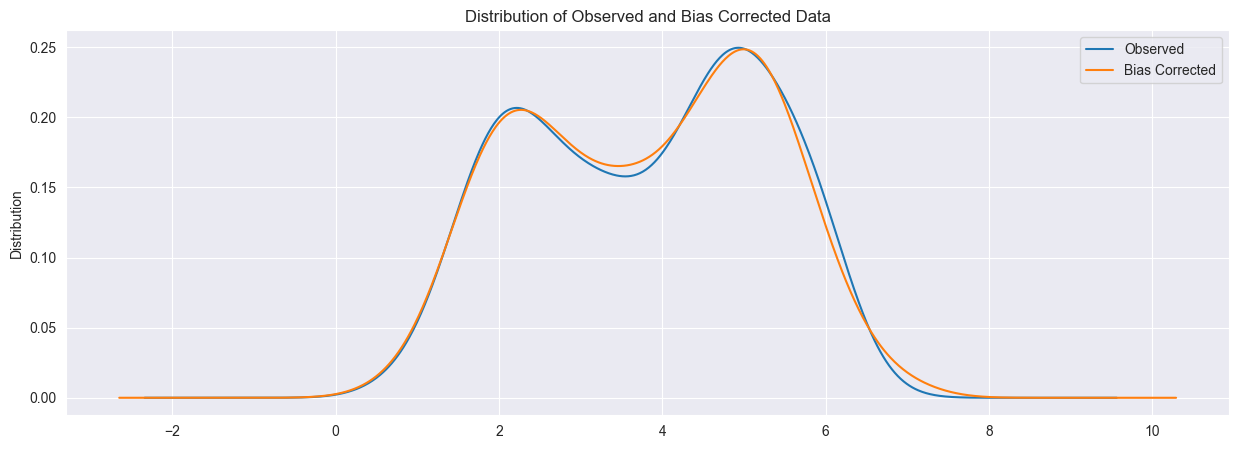

In [25]:
from modules import nested_bias_correction
fig, ax = plt.subplots(figsize=(15, 5))
nbc = nested_bias_correction(y[: downscaled.index[-1]], downscaled[y.index[0]:])

y[: nbc.index[-1]].plot(kind='kde', ax=ax)
nbc.plot(kind='kde', ax=ax)
plt.ylabel('Distribution')
plt.legend(['Observed', 'Bias Corrected'])
plt.title('Distribution of Observed and Bias Corrected Data');

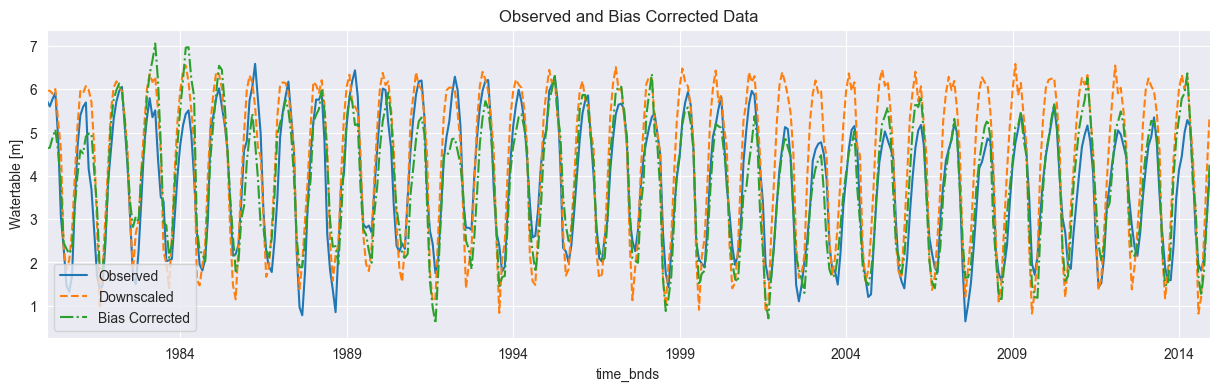

In [26]:
from modules import nested_bias_correction
fig, ax = plt.subplots(figsize=(15, 4))
y[: nbc.index[-1]].plot(ax=ax)
downscaled[y.index[0]:].plot(ax=ax, style=["--"])
nbc[y.index[0]:].plot(ax=ax, style=["-."])
plt.ylabel('Watertable [m]')
plt.legend(['Observed', 'Downscaled','Bias Corrected'])
plt.title('Observed and Bias Corrected Data');

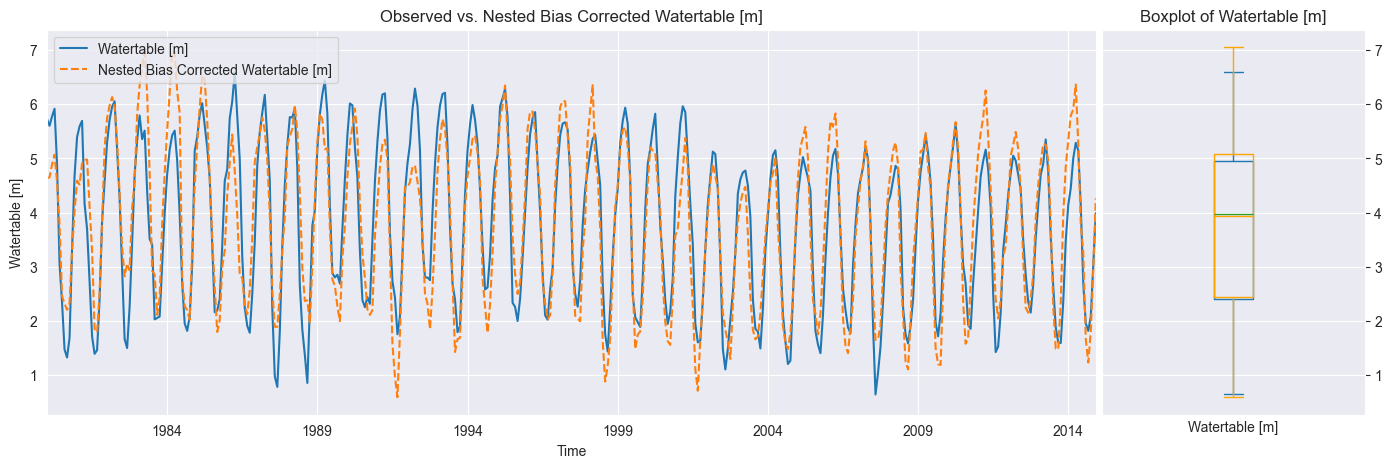

In [27]:
# Some values are negative which is not possible. So, replace negative values with 0 
plot_compare_time_series_and_boxplot(y, nbc, variable_name="Watertable [m]", alt_legend="Nested Bias Corrected")

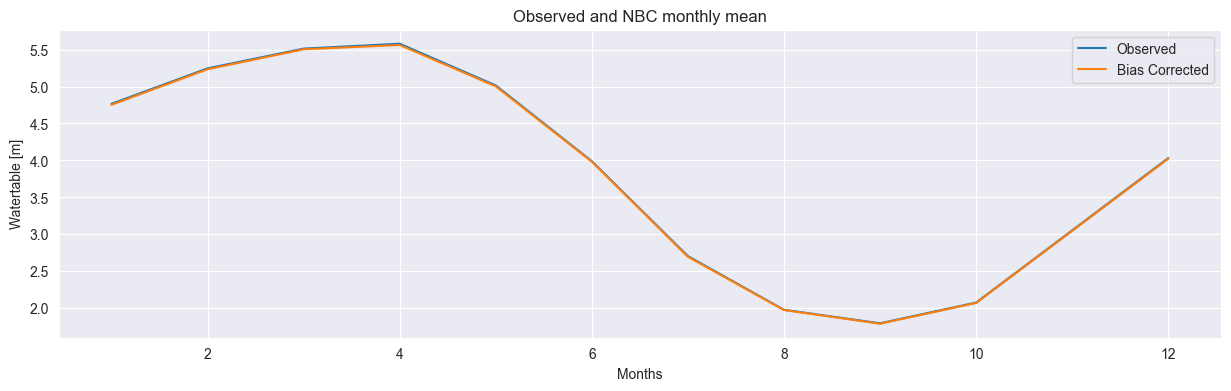

In [28]:
fig, ax = plt.subplots(figsize=(15, 4))

# Plot observed data
y[:nbc.index[-1]].groupby(y[:nbc.index[-1]].index.month).mean().plot(label="Observed")
# Plot bias-corrected data
nbc[y.index[0]:].groupby(nbc[y.index[0]:].index.month).mean().plot(label="Bias Corrected")
# Add labels and title
plt.ylabel("Watertable [m]")
plt.xlabel("Months")
plt.title("Observed and NBC monthly mean")
# Add legend
plt.legend()

Text(0.5, 1.0, 'Observed and LinScaled monthly mean')

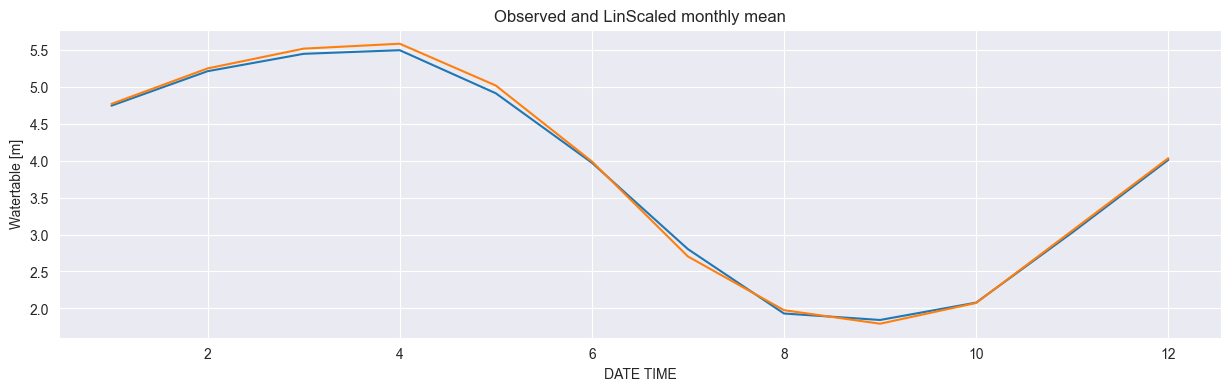

In [29]:
fig, ax = plt.subplots(figsize=(15,4))
lin_scl = linear_scaling(y, downscaled, method="multiplicative").loc[y.index[0]: ]
lin_scl.groupby(lin_scl.index.month).mean().plot()
y[: nbc.index[-1]].groupby(y[: nbc.index[-1]].index.month).mean().plot()
plt.ylabel("Watertable [m]")
plt.title("Observed and LinScaled monthly mean")

In [30]:
params = {
        "mean_obs": y[:nbc.index[-1]].mean(),
        "std_obs": y[:nbc.index[-1]].std(),
        "skew_obs": y[:nbc.index[-1]].skew(),
        "mean_nbc": nbc[y.index[0]:].mean(),
        "std_nbc": nbc[y.index[0]:].std(),
        "skew_nbc": nbc[y.index[0]:].skew()
}

# Convert to DataFrame
stats_df = pd.DataFrame(params, index=["Value"])
stats_df

,mean_obs,std_obs,skew_obs,mean_nbc,std_nbc,skew_nbc
Value,3.811849,1.471269,-0.136827,3.802498,1.480547,-0.08361


In [31]:
temp = y[: nbc.index[-1]].copy().to_frame()
temp["Raw"] = downscaled[y.index[0]:]
temp["NBC_Python"] = nbc
temp.to_csv(r"C:\Users\Acer\Desktop\Thesis\Meeting 07\Codes\MLDownscale\Data.csv")

In [ ]:
## Fix for autocorrelation in NBC

# # Create a lagged version of the series
# y_predicted_lagged = y_predicted.shift(1)

# # Combine into a DataFrame
# df = pd.DataFrame({
#     'current': y_predicted,
#     'lagged': y_predicted_lagged
# })

# # Drop rows where lagged is NaN (no prior month)
# df = df.dropna()

# Group by current month and compute correlation
# rho_predicted = df.groupby(df.index.month).apply(
#     lambda x: x['current'].corr(x['lagged'])
# )

# temp = pd.DataFrame({
#     'current': y,
#     'lagged': y.shift(1)
# })
# temp.head(20)

,current,lagged
DATE TIME,,
1980-01-01,5.7300,NaN
1980-02-01,5.6025,5.7300
1980-03-01,5.7760,5.6025
1980-04-01,5.9175,5.7760
1980-05-01,4.8875,5.9175
1980-06-01,3.0540,4.8875
1980-07-01,2.3375,3.0540
1980-08-01,1.4675,2.3375
1980-09-01,1.3200,1.4675
